## Modelowanie wieloagentowe

### Bogumił Kamiński

In [1]:
using Statistics

In [2]:
using Plots

## 1. Podstawy projektowania i analizy wyników eksperymentu symulacyjnego

Gramy w taką grę.

Losujemy liczby z rozkładu $U(0,1)$ tak długo aż ich suma przekroczy $1$. Jaka jest wartość oczekiwana liczby losowań.

Oznaczmy przez $X$ zmienną losową oznaczającą liczbę losowań. Ponieważ jest to liczba nieujemna mamy:

$$
E(X) = \sum_{i=1}^{+\infty}\Pr(X\geq i)
$$

Niech $U_i\sim U(0,1)$, wtedy mamy:

$$
\Pr(X\geq i) = \Pr\left(\sum_{k=1}^{i-1} U_k \leq 1\right) = \frac{1}{(i-1)!}
$$

a więc:

$$
E(X) = \sum_{i=0}^{+\infty}\frac{1}{i!} = e
$$

In [3]:
function esample()
    i = 0
    s = 0.0
    while true
        i += 1
        s += rand()
        s > 1.0 && return i
    end
end

esample (generic function with 1 method)

Chcemy oszacować wartość oczekiwaną wyniku symulacji z *dokładnością* równą 0.01 z poziomem ufności 95%.
Poprzez *dokładność* $w$ będziemy rozumieli szerokość przedziału ufności.

Reguła kciuka to:

$$
n = \frac{16\hat{\sigma}^2}{w^2}
$$

gdzie $\hat{\sigma}$ to oszacowanie wariancji rozkładu badanej zmiennej.

Procedura:
1. przeprowadzamy wstępne symulacje, żeby zebrać wyniki dla oszacowania wielkości próby
2. przeprowadzamy symulację właściwą

In [4]:
@time burnin = [esample() for _ in 1:1024]

  0.035018 seconds (74.88 k allocations: 4.651 MiB, 105.98% compilation time)


1024-element Vector{Int64}:
 2
 4
 3
 2
 2
 4
 3
 4
 2
 3
 3
 2
 2
 ⋮
 3
 3
 2
 2
 3
 2
 4
 3
 3
 2
 2
 2

In [5]:
w = 0.01

0.01

In [6]:
n = round(Int, 16*var(burnin) / w^2)

134872

In [7]:
experiment = [esample() for _ in 1:n]

134872-element Vector{Int64}:
 2
 3
 4
 2
 2
 3
 2
 3
 2
 5
 2
 3
 2
 ⋮
 2
 4
 2
 3
 3
 2
 2
 4
 4
 3
 3
 2

In [8]:
dist = [mean(rand(experiment, length(experiment))) for _ in 1:10_000]

10000-element Vector{Float64}:
 2.7150112699448368
 2.7167907349190346
 2.720638827925737
 2.715293018565751
 2.7190298950115666
 2.725584257666528
 2.716405184174625
 2.7203348359926447
 2.7215063171006584
 2.7194376890681533
 2.7200679162465153
 2.7160122189928226
 2.7168574648555666
 ⋮
 2.7158046147458332
 2.7193709591316213
 2.7234563141348835
 2.7168278071059966
 2.720564683551812
 2.718992822824604
 2.720312592680467
 2.7153597485022836
 2.721862210095498
 2.719897384186488
 2.720816774423157
 2.7175321786582836

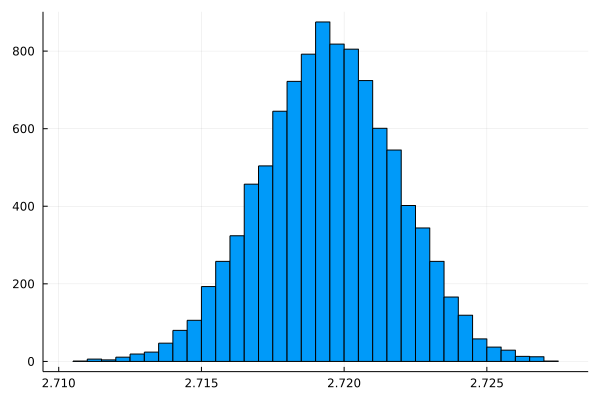

In [9]:
histogram(dist, legend=false)

In [10]:
q = quantile(dist, [0.025, 0.975])

2-element Vector{Float64}:
 2.7147886514621273
 2.7240642980010676

In [11]:
diff(q)

1-element Vector{Float64}:
 0.009275646538940308

In [12]:
q .- exp(1)

2-element Vector{Float64}:
 -0.0034931769969177573
  0.00578246954202255

### Zadanie

Wróćmy do omawianego wcześniej modelu wyceny opcji:

In [13]:
using Statistics

function v_asian_sample(T, r, K, σ, X₀, m)
    X = X₀
    hatX = zero(X)
    Δ = T / m
    for i in 1:m
        X *= exp((r-σ^2/2)*Δ + σ*sqrt(Δ)*randn())
        hatX += X
    end
    return exp(-r*T) * max(hatX/m - K, 0)
end

"""
    v_asian(T, r, K, σ, X₀, m, n)

Aruments:
* T: contract period
* r: interest rate
* K: threshold price
* σ: asset price volatility
* X₀: initial price
* m: simulation granularity
* n: number of simulation replications
"""
function v_asian(T, r, K, σ, X₀, m, n)
    res = [v_asian_sample(T, r, K, σ, X₀, m) for i in 1:n]
    return mean(res)
end

v_asian

Dla wyjściowej parametryzacji:

In [14]:
v_asian(1.0, 0.05, 55.0, 0.3, 50.0, 1000, 1000)

2.0040181375678916

1. Wylicz ile jest potrzeba powtórzeń eksperymentu, żeby zrobić wycenę opcji z dokładnością 0.2 na 95% poziomie ufności.
2. Zwizualizuj jak wycena opcji zależy od parametru $K$.